## Credit VaR

Credit VaR is defined in the usual way Value at Risk measures are defined (i.e. as percentile of a loss distribution). 

In this case we are concerned with the default risk associated to one or multiple counterparties in our portfolio (while previously VaR was concerned with market risk).

To compute Credit VaR we need to consider the exposure $EE$ at the default date $\tau$ defined as the sum of the discounted cash flows at the default; the corresponding loss is then given by:

$$ L(\tau, \hat{T}) = (1 − R)\cdot EE(\tau)$$

where $\hat{T}$ is the risk horizon and $L$ is non-zero only in scenarios of early default of the counter-party. 

Given the above definitions we can express the Credit VaR as the q-quantile of $L(\tau, \hat{T})$.
In this case the time horizon considered is usually one year and the chosen standard percentile is the 99.9th, so that the returned loss is exceeded only in 1 case out of 1000.

### Credit Var and MC Simulation
Credit VaR can be calculated through a simulation of the basic financial variables underlying the portfolio up to the risk horizon and the simulation clearly includes the default of the counter-parties.

The portfolio is priced in every simulated scenario at the risk horizon, including defaults, obtaining the distribution of the losses from which it is then straightforward to derive the Credit VaR.

Let's compute Credit VaR in a simple case of a portfolio of 20 zero coupon bonds with 8% default probability ($R=40\%$) and a risk-free rate of 0.01.

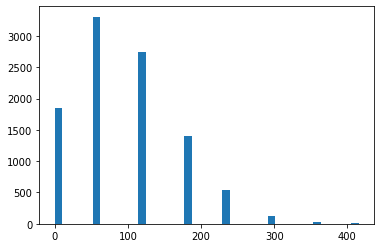

In [4]:
# Credit VaR of 20 bonds
from datetime import date
from dateutil.relativedelta import relativedelta
from finmarkets import DiscountCurve, CreditCurve
from scipy.stats import uniform
import numpy as np
from matplotlib import pyplot as plt

np.random.seed(1)
N = 20
FV = 100
R = 0.4
obs_date = date.today()
pillars = [obs_date + relativedelta(years=i) for i in range(2)]
dfs = [1/(1+0.01)**i for i in range(2)]
dc = DiscountCurve(obs_date, pillars, dfs)
cc = CreditCurve(pillars, [1., 0.92])

losses = []
trials = 10000
for _ in range(trials):
    x = uniform.rvs(size=N)
    loss = 0
    for i in range(N):
        if x[i] > cc.ndp(pillars[-1]):
            loss += dc.df(pillars[-1])*(1-R)*FV
    losses.append(loss)    
    
plt.hist(losses, bins=40)
plt.show()

In [5]:
np.percentile(losses, [99.9])

array([356.43564356])

Should be at this point clear that all the consideration done previously on correlated defaults have an impact also here.

### Credit VaR and One Factor Copula Model

Consider a portfolio made of similar assets. As an approximation assume that the probability of default is the same for each counter-party and that the correlation between each pair is the same and equal to $\rho$. 

If we use the One Factor Copula model to describe the correlated defaults we get

$$ Q_M(T)=\Phi\left(\cfrac{\Phi^{-1}[Q(T)]-M\sqrt{\rho}}{\sqrt{1-\rho}}\right)$$

But this expression gives us also the percentage of defaults by time $T$ given the parameter $M$. 
Indeed if you a have $n$ counter-parties with the same default probability $Q_M(T)$ the **percentage of defaults** at time $t$ is $Q_M$ itself

$$\textrm{% of defaults} = \textrm{nDefaults}/n = (n\cdot Q_M)/n$$

Since $M$ is distributed according to a standard normal we can be $X\%$ certain that its value will be greater than $\Phi^{-1}(1−X) = -\Phi^{-1}(X)$, where the last equality holds due to the symmetry of the Gaussian distribution (e.g. $\Phi^{-1}(0.95) = -\Phi^{-1}(0.05))$.

<img src="certain_for_X.png">

But once $T$ has been fixed the only random variable in $Q_M$ is $M$, therefore we can say that we are $X\%$ certain that the percentage of defaults over $T$ years on a large portfolio will be **less** than $V(X, T)$ where

$$ V(X, T)=\Phi\left(\cfrac{\Phi^{-1}[Q(T)]-\hat{m}\sqrt{\rho}}{\sqrt{1-\rho}}\right) = \Phi\left(\cfrac{\Phi^{-1}[Q(T)]+\Phi^{-1}(X)\sqrt{\rho}}{\sqrt{1-\rho}}\right)$$

If we interpret $X\%$ as a confidence level and $T$ as the time horizon, a rough estimate of the Credit VaR is therefore $P ( 1 − R ) V ( X, T )$ , where $P$ is the size of the portfolio and $R$ is the recovery rate.

Suppose that a bank has a total of €100 million of retail exposures. 
The 1-year probability of default averages to 2% and the recovery rate averages to 60%. The copula correlation parameter is estimated as 0.1. The associated Credit VaR can be computed as follows

In [6]:
# credit VaR with gaussian copula
from scipy.stats import norm
from math import sqrt

M = 100e6
Q = 0.02
R = 0.6
rho = 0.1
cr_var = M*(1-R)*norm.cdf((norm.ppf(0.02)+norm.ppf(0.999)*sqrt(rho))/(sqrt(1-rho)))
print (cr_var)

5129484.291976927


### CreditMetrics

Another popular approach to compute Credti VaR is CreditMetrics. It involves estimating a probability distribution of credit losses by carrying out Monte Carlo simulations where the credit rating are changes of all counter-parties.

Imagine we would like to determine the probability distribution of losses over 1-year period.
On each simulation, the new credit ratings of each counter-party is computed (default included). The portfolio value is than computed to determine the eventual losses considering that the asset value depends on the corresponding rating (in case of default we need to compute the loss given default).

<img src="credit_metrics_table.png">

### Credit Valuation Adjustment

Suppose you have a portfolio of derivatives with a counter-party. If the counter-party defaults and the present value of the portfolio at default is positive to the surviving party, then the surviving party only gets a recovery fraction of the portfolio value from the defaulted entity. 

If however the present value is negative to the surviving party, it has to pay it in full to the liquidators of the defaulted entity. This creates and asymmetry that, once one has done all calculations, says that the value of the deal under counter-party risk is the value without counter-party risk minus a positive adjustment, called Credit Valuation Adjustment (CVA).

It can be expressed in the following way:

$$\textrm{CVA} = ( 1 − R )\int^{T}_{0} D(t)\cdot EE(t) dQ(t) $$

where $T$ is the latest maturity in the portfolio, $D$ is the discount factor, $EE$ is the expected exposure or $\mathbb{E}[ \textrm{max(0, NPV portfolio)}]$ and $dQ$ is the probability of default between $t$ and $t+dt$. 

For an easier computation it is natural to discretize the above integral and use a time grid going from 0 to the maturity of the portfolio:

$$\textrm{CVA} = ( 1 − R ) \sum_i D(t_i)\cdot EE(t_i) Q(t_{i − 1}, t_i)$$

It is important to notice that while Credit VaR measures the risk of losses you face due to the possible default of some counter-parties you are having business with, CVA measures the pricing component of this risk, i.e. the adjustment to the price of a product due to this risk.

### Debit Valuation Adjustment

This very same adjustment seen from the point of view of our counter-party is positive, and is called Debit Valuation Adjustment, DVA. It is positive because the early default of the client itself would imply a discount on the client payment obligations, and this means a gain in a way. So the client marks a positive adjustment over the risk free price by adding the positive amount called DVA.

Basically when both parties have the possibility to default, they consistently include both defaults into the valuation. Hence every party needs to include its own default besides the default of the counter-party into the valuation. So they will mark a positive CVA to be subtracted and a positive DVA to be added to the default risk free price of the deal. The CVA of one party will be the DVA of the other one and vice versa.

$$\textrm{price = default risk free price + DVA - CVA}$$

Now, since
$$\textrm{default risk free price(A) = − default risk free price(B)}$$

$$\textrm{DVA(A) = CVA(B)}$$

$$\textrm{DVA(B) = CVA(A)}$$

we get that eventually
$$\textrm{price(A) = − price(B)}$$

so that both parties agree on the price, or, we could say, there is money conservation.

### CVA Computation
The computation of the CVA is easily carried on with Monte Carlo simulation. First simulate the development of your portfolio (its NPV) at each time point for each MC scenario. Then calculate the CVA using one of the previous definitions. Finally average the CVA of all the scenarios to get its best estimate.

In case of zero coupon bonds the computation of the CVA can be further simplified. Indeed in this case the exposure of the investor is equal to the face value of the bond, so it is enough to loop through each days from the observation date to the maturity of the bond and compute the CVA. 

Imagine a 3-years bond with a face value $FV$ = €100.
The bond issuer has the following default probabilities 10%, 20% and 30% for 1, 2 and 3 years respectively (the recovery rate is 40%). The risk free rate is 3%.

In [10]:
# cva ZCB
from dateutil.relativedelta import relativedelta
from finmarkets import DiscountCurve, CreditCurve
import math

np.random.seed(1)
FV = 100
R = 0.4
obs_date = date.today()
pillars = [obs_date + relativedelta(years=i) for i in range(4)]
dfs = [1/(1+0.03)**i for i in range(4)]
dc = DiscountCurve(obs_date, pillars, dfs)
cc = CreditCurve(pillars, [1., 0.90, 0.8, 0.7])

cva = 0
for t in range(365*3):
    d = obs_date + relativedelta(days=t) 
    cva += dc.df(d)*(cc.ndp(d)-cc.ndp(d+relativedelta(days=1)))
cva *= FV*(1-R)
                     
print (cva)
print (FV*dc.df(pillars[-1]))

17.225686489343786
91.51416593531596


If we assume that the recovery payments are done at the maturity date of the zero coupon bond the CVA calculation can be simplified further, indeed

$$ \textrm{CVA} = (1-R)\cdot FV \cdot \sum_{i=1}^{n} D(d_i)\cdot Q(d_{i-1}, d_i) $$
becomes
$$ \textrm{CVA} = (1-R)\cdot FV\cdot D(d_n)\cdot\sum_{i=1}^{n} Q(d_{i-1}, d_i) = (1-R)\cdot FV\cdot Q(d_{0}, d_n)$$


In [ ]:
# super-simplified form

In [ ]:
# risk-free price

## Portfolio Optimization

Portfolio optimization models look for the optimal way to make investments. Usually investors expect 
either a maximum return for a given level of risk or a given return for a minimum risk so these models
are typically based on two criteria: maximization of the expected return and/or minimization of the risk.

There is a variety of measures of risk and the most popular is the variance in return. 

### Some Notation

* expected return: 
    $$\mathbb{E}(R_{p}) = \sum _{i}w_{i} \mathbb{E}(R_{i})$$
  where $R_{p}$ is the return on the portfolio, $R_{i}$ is the return on
  asset $i$ and $w_{i}$ is the weighting of component asset $i$
  (that is, the proportion of asset $i$ in the portfolio) and
  $\sum_{i}w_i = 1$ and $0 \le w_i \le 1$;
* portfolio return variance:
  $$ \sigma _{p}^{2} = \sum _{i}\sum _{j}w_{i}w_{j}\sigma _{ij}$$ 
  where
  $\Sigma = \sigma _{ij}=\sigma _{i}\sigma _{j}\rho _{ij}$ is the (sample)
  covariance of the periodic returns on the two assets, $\rho_{ij}$ is the correlation coefficient. In matrix notation:
  $$\sigma_p^2 = \mathbf{w^T}\Sigma\mathbf{w}$$
  where $\mathbf{w} = (w_1, w_2,\ldots,w_N)$ is the vector of weights.
* portfolio return volatility (standard deviation):
  $$ \sigma _{p}= \sqrt{\sigma _{p}^{2}}$$

### The Markowitz Mean/Variance Portfolio Model
The portfolio model, introduced by Markowitz, assumes an investor has two considerations when constructing an investment portfolio: expected return and variance in return (i.e., risk, since it measures the variability in realized return around the expected return). 

The Markowitz model requires two major kinds of information: 

* the estimated expected return for each candidate investment;
* the covariance matrix of returns. 

The latter characterizes not only the individual variability of the return on each investment, but also how each investment’s return tends to move with other investments. 

Throughout this lesson we will use real market data stored in [portfolio_data.csv](https://drive.google.com/file/d/1srCzNlKVY_LHRpkaKoUynnmI0KImfT6Y/view?usp=sharing).
The sample includes, for each entry, a date and the corresponding closing price of five company stocks:

In [ ]:
import pandas as pd

df = pd.read_csv("portfolio_data.csv", index_col="date")

<img src="portfolio_sample.png">

With $\tt{pandas}$ the main characteristics of these time series can be easily computed (e.g. daily returns, covariance matrix):

In our sample correlations are rather small and all the stocks are positively correlated.

In [ ]:
# returns daily and annualized

# covariance

Simulating a large number of set of weights to construct portfolios with the five stocks shown before, we can see which is the distribution of these portfolios in terms of return and volatility. In this case no attempt of any optimization whatsoever has been made.

In principle investors may use short sales in their portfolios (a portfolio is short in those stocks with negative weights). Although short selling extends the set of possible portfolios we are not going to consider them here.

<img src="return_variance.png" width=500>

### Optimization

Markowitz model states that the weights $w_i$ should be chosen such that the portfolio has the minimum volatility (variance). So the application of Markovitz model reduces to an optimization problem

$$\underset{\mathbf{w}}{\min}\{\sigma_P^2\}= \underset{\mathbf{w}}{\min}\{\mathbf{w^T}\Sigma\mathbf{w}\}$$

with the constraint $\sum_{i}w_i = 1$ and $0 \le w_i \le 1$.

With have already seen how to solve minimization problems in $\tt{python}$ so we just need to repeat the usual steps seen before.

In [ ]:
# markowitz
import numpy as np
from scipy.optimize import minimize

In [ ]:
# expected returns

The solution recommends about 44% of the portfolio be invested in AAPL, about 7% in AMZN, 12% in FB and so on...
The expected return is about 23%, with a variance of about 0.036 or,
equivalently, a standard deviation of 0.19.

In this example we based the model simply on statistical data derived from daily returns. However it could be possible, rather than use historical series for estimating the
expected return of an asset, to base this estimate on information about its expected future performance.

### Efficient Frontier and Parametric Analysis
There is no precise way for an investor to determine the “correct” trade off between risk and return. If an investor wants a higher expected return, she generally has to “pay for it” with higher risk. 
Thus, one is frequently interested in looking at the relative distribution of the two. 

In finance terminology, we
would like to trace out the **efficient frontier** of return and risk. 
To determine it we need to solve for the minimum variance
portfolio over a range of values for the expected return.

In [ ]:
#efficient frontier

<img src="efficient_frontier.png">

### Criticisms to Markowitz Model

Despite the significant utility of the Markowitz theory, there are some major limitations in this model:

* it is difficult to forecast asset returns with accuracy using historical data. As return estimations have a much larger impact on the asset allocations, small changes in return assumptions can lead to inefficient portfolios. Therefore, the model tends to lead to highly concentrated portfolios (out-of sample weights) that do not offer as much diversification benefits;
* the model assumes that asset correlations are linear. In reality, asset correlations move dynamically, changing with the market cycles. During the global financial crisis, asset cor- relations approached almost 1, so if anything, diversification seemed to have insignificant impacts on the portfolios;
* last but not the least, the model assumes normality in return distributions. Therefore, it does not factor in extreme market moves which tend to make returns distributions either skewed, fat tailed or both.

### Portfolios with a Risk-Free Asset
When one of the asset of the portfolio is risk free, then the efficient frontier has a particularly simple form: a line, the *capital allocation line* (CAL). 

The slope of the this line measures the trade off between risk and return: a higher slope means that investors receive a higher expected
return in exchange for taking on more risk. 
The CAL aids investors in choosing how much to invest in a risk-free asset and one or more risky assets.

The simplest example is a portfolio containing two assets: one risk-free (e.g. treasury bill) and one risky (e.g. a stock).

Assume that the expected return of the treasury bill is $\mathbb{E}[R_f] = 3\%$ and its risk is 0%. Further, assume that the expected return of the stock is $\mathbb{E}[R_r] = 10\%$ and its standard deviation is $\sigma_r = 20\%$. The question that needs to be answered for any individual investor is how much to invest in each of these assets.

The expected return ($\mathbb{E}[R_p]$) of this portfolio is calculated as follows:

$$\mathbb{E}[R_p] = \mathbb{E}[R_f]\cdot w_f + \mathbb{E}[R_r] \cdot ( 1 − w_f )$$
where $w_f$ is the relative allocation to the risk-free asset.

The calculation of risk for this portfolio is simple because the standard deviation of the treasury bill is 0%. Thus, risk is calculated as:

$$\sigma_p = ( 1 − w_f ) \cdot \sigma_r$$

In this very simple example, if an investor were to invest 100% into the risk-free asset ($w_f = 1$),
the expected return would be 3% and the risk of the portfolio would be 0%. Likewise, investing
100% into the stock ($w_f = 0$) would give an investor an expected return of 10% and a portfolio risk
of 20%. If the investor allocated 25% to the risk-free asset and 75% to the risky asset, the portfolio
expected return and risk calculations would be:

$$\mathbb{E}[R_p] = ( 3\% \cdot 25\% ) + ( 10\% \cdot 75\% ) = 0.75\% + 7.5\% = 8.25\%$$

$$\sigma_p = 75\%\cdot 20\% = 15\%$$

Applying the same steps to our example we can consider an additional risk-free asset with an expected return of 10% and repeat the minimisation to determine the efficient frontier of
the resulting portfolio. Notice how the objective function is almost the same while the constraint on the target return now includes also the risk-free asset.

In [ ]:
# markowitz with risk free

<img src="cal.png">

The efficient frontier has become a straight line, tangent to the
frontier of the risky assets only. 

When the target is 10% the entire investment is allocated to the
risk-free asset, as the target increases the fraction of the risky assets grows proportionally to the volatility.
It is important to note that in general the relative proportions devoted to risky investments do not change. Only the allocation between the risk-free asset and the risky assets changes.

### The Sharpe Ratio
The goal of an investor who is seeking to earn the highest possible expected return for any 
level of volatility is to find the portfolio that generates the steepest possible line
when combined with the risk-free investment. The slope of this line is called the 
*Sharpe ratio* of the portfolio.

For some portfolio $p$ of risky assets let

* $R_p$ its expected return;
* $\sigma_p$ its standard deviation in return;
* $r_0$ the return of a reference risk-free asset.

A plausible single measure (as opposed to the two measures, risk and return) of attractiveness of a portfolio $p$ is the Sharpe ratio defined as

$$ (R_p - r_0 ) / \sigma_p $$

In words, it measures how much additional return we achieved for the additional risk we took on, relative to putting all our money in a risk-free asset.
The portfolio that maximizes this ratio has a certain well-defined appeal. Suppose:

* $R_\textrm{target}$ our desired target return;
* $w_p$ the fraction of our wealth we place in portfolio $p$ (the rest placed in the risk-free asset).

To meet our return target, we must have:

$$ ( 1 - w_p ) * r_0 + w_p * R_p = R_\textrm{target} $$

The standard deviation of our total investment is: $w_p\cdot \sigma_p$.
Solving for $w_p$ in the return constraint, we get:

$$ w_p = \cfrac{( R_\textrm{target} – r_0)}{( R_p – r_0)} $$

Thus, the standard deviation of the portfolio is:

$$ w_p\cdot \sigma_p = \Big[\cfrac{( R_\textrm{target} – r_0)}{(R_p – r_0)}\Big]\cdot \sigma_p $$

Minimizing the portfolio standard deviation means:

$$ \min(\Big[\cfrac{( R_\textrm{target} – r_0)}{(R_p – r_0)}\Big]\cdot \sigma_p)\implies\max(\cfrac{R_p – r_0}{\sigma_p}) $$

So, regardless of our risk/return preference, the money we invest in risky assets should be invested in the risky portfolio that maximizes the Sharpe ratio since it is the one that minimize the variance at the same time .

In [ ]:
# sharpe ratio

<img src="sharpe_ratio.png">

Notice that the relative proportions of the stocks are the same as in the previous case where we explicitly included the risk-free asset (0.12, 0.54, 0., 0., 0.33).

So the optimization using the Sharpe ratio gives us a portfolio that is
on the minimum volatility efficient frontier, and gives the maximum
return relative to putting all our money in the risk-free asset.

Usually, any Sharpe ratio greater than 1.0 is considered acceptable to good by investors. A ratio higher than 2.0 is rated as very good. A ratio of 3.0 or higher is considered excellent. A ratio under 1.0 is sub-optimal.

## Capital Asset Pricing Model

The Capital Asset Pricing Model (CAPM) describes the relationship between the expected return of assets and the systematic risk of the market.

CAPM indicates that the expected return of an asset or a portfolio is equal to the risk-free return plus a risk premium. The assumption of CAPM is that investors are rational and want to maximize return and reduce risk as much as possible and so its goal is to calculate what return an investor can expect to make for a given risk premium over the risk-free rate.

Mathematically, we can define CAPM formula as follows
$$r_i = r_f + \beta_i(r_m-r_f)$$
where:

* $r_i$ is the expected return of the $i^{th}$ security;
* $r_f$ is the risk-free rate with zero standard deviation (an example of a risk-free asset includes Treasury Bills as they are backed by the U.S. government);
* $\beta_i$ is a measure of a stock's volatility in relation to the overall market (e.g. S\&P 500). In other words, it represents the slope of the regression line, which is the market return vs. the individual stocks return. $\beta$ is used in the CAPM to describe the relationship between systematic risk, or market risk, and the expected return of an asset. By definition, we say that the overall market has a beta of 1.0 and individual stocks are ranked by how volatile they are relative to the market. If $\beta$ of an individual stock = 1.0, this means its price is perfectly correlated with the market, i $\beta < 1.0$, which is referred to as "defensive", this indicates the security is theoretically less volatile than the market, while if $\beta > 1.0$, or "aggressive", this indicates the assets price is more volatile than the market;
* $r_m - r_f$ is the risk premium ($r_m$ denotes the market return and includes all securities in the market.

To use CAPM it is enough to pick individual stocks or portfolios, and compare them to different indexes (as proxies for the whole market). The point is to find stocks that have high $\beta$, and portfolios that have high $\alpha$. High $\beta$ values mean that the stock fares better than index, so those stocks have a chance at beating the market. $\alpha$ values above zero mean that your portfolio gives positive return no matter what the market does.

In order to see an example of CAPM application we use [capm.csv](https://drive.google.com/file/d/1G4U8foyhq9agGPs8cg83-aY4qU8K3jJI/view?usp=sharing) file which contains the historical series of S&P500 and of some stocks.
As usual with $\tt{pandas}$ we can inspect the file and compute some useful quantities like daily and annualized expected returns.

In [ ]:
# read capm file
import pandas as pd

### Calculate $\beta$ and CAPM for each Stock
To recap $\beta$ is the slope of the regression line of the market return vs stock return plot (and $\alpha$ is the intercept of this line with the $y$ axis).

These quantities can be calculated with $\tt{numpy.polyfit}$ passing as inputs the market and the stock return lists. 

<img src="capm_fit.png">

With the daily returns and $\beta$ of each stock, we can calculate the capital asset pricing model. First, we can calculate the average daily return of the market and annualize this return by multiplying it by the number of trading days in a year.
Assuming a risk-free rate of 1%, we can then calculate CAPM using its definition.

In [ ]:
# beta and ER

Now that we have the $\beta$ of each individual stock we can calculate the CAPM for a portfolio made of the same stocks (we assume equal weights for simplicity).
It is enough indeed to perform a weighted sum of of the expected return according to the model of each stock.

In [ ]:
# ER of portfolio  

The expected return of the portfolio is roughly 10\% and this is what an investor should expect according to CAPM.

As we have seen the whole model is about plotting a line in a scatter plot. It’s not a very complex model. Assumptions under the model are even more simplistic. For example:

* expect that all investors are rational and they avoid risk;
* everyone have full information about the market;
* everyone have similar investment horizons and expectations about future movements;
* stocks are all correctly priced.

Moreover, this is a model from the 1950s. Market dynamics were different back then. And of course, this is a retrospective model. We cannot know how future stock prices move and how the market behaves.

## Risk Parity Portfolio

An alternative approach to Markowitz theory is given by the *risk parity*. A risk parity portfolio is an investment allocation strategy which focuses on the allocation of risk, rather than the allocation of capital. 

A risk parity (equal risk) portfolio is characterised by having equal risk contributions to the total risk from each individual asset. 
Risk parity allocation is also referred to as equally-weighted risk contributions portfolio method. Equally-weighted risk contributions is not about having the same volatility, it is about having each asset contributing in the same way to the portfolio overall volatility. 

For this we will have to define the contribution of each asset to the portfolio risk. **This allocation strategy has gained popularity in the last decades since it is believed to provide better risk adjusted return than capital based allocation strategies.**

Consider a portfolio of $N$ assets: $x_1,\ldots , x_N$ where as usual the weight of the asset $x_i$ is denoted by $w_i$. The $w_i$ form the allocation vector $\mathbf{w}$. Let us further denote the covariance matrix of the assets as $\Sigma$. The volatility of the portfolio is then defined as:

$$\sigma_p={\sqrt {\mathbf{w^T}\Sigma \mathbf{w}}} = \sum _{i=1}^{N}\sigma _{i}\qquad\textrm{with}~\sigma _{i} = w_{i}\cdot \cfrac{\partial\sigma_p}{\partial w_{i}}={\cfrac {w_{i}(\Sigma \mathbf{w})_{i}}{\sqrt {\mathbf{w^T}\Sigma \mathbf{w}}}}$$
so that $\sigma _{i}$ can be interpreted as the contribution of asset $i$ in the portfolio to the overall risk of the portfolio.
Equal risk contribution then means $\sigma _{i} =\sigma _{j}$ for all
$i,j$ or equivalently $\sigma _{i}=\sigma_p/N$. So

$$\sigma _{i} = \cfrac{\sigma_p}{N}={\cfrac {w_{i}(\Sigma \mathbf{w})_{i}}{\sqrt {\mathbf{w^T}\Sigma \mathbf{w}}}}\implies w_{i} = \frac {\sigma_p^{2}}{(\Sigma \mathbf{w})_{i}N}$$

Since we want the previous expression to be true for each $i$, the solution for the weights can be found by solving the minimisation problem

$$\underset{\mathbf{w}}{\min } \sum _{i=1}^{N}\left[w_{i}-{\frac {\sigma_p^{2}}{(\Sigma \mathbf{w})_{i}N}}\right]^{2}$$

$$
\begin{split}
\sigma_p={\sqrt {\mathbf{w^T}\Sigma \mathbf{w}}} & =
\sqrt{
\begin{bmatrix}
w_{1} \\
w_{2}
\end{bmatrix}
\begin{bmatrix}
\sigma_{11} & \sigma_{21} \\
\sigma_{12} & \sigma_{22} 
\end{bmatrix}
\begin{bmatrix}
w_{1} & w_{2} \\
\end{bmatrix}
}\\
&=
\sqrt{
\begin{bmatrix}
w_{1} \\
w_{2}
\end{bmatrix}
\begin{bmatrix}
w_{1}\sigma_{11} + w_{2}\sigma_{21} & w_{1}\sigma_{12} + w_{2}\sigma_{22} \\
\end{bmatrix}
} \\
&= \sqrt{
w_{1}w_{1}\sigma_{11} + w_{2}w_{1}\sigma_{21} + w_{1}w_{2}\sigma_{12} + w_{2}w_{2}\sigma_{22} }
\end{split}
$$


$$\cfrac{\partial\sigma_p}{\partial w_1} = \cfrac{1}{2}\cdot\cfrac{2\cdot w_1\sigma_{11} + 2\cdot w_{2}\sigma_{21}}{\sigma_p} = \cfrac{w_1\sigma_{11} + w_{2}\sigma_{21}}{\sigma_p} = \cfrac{(\Sigma \mathbf{w})_{1}}{\sigma_p}$$

In [ ]:
# risk parity

In [ ]:
# contribution of each asset

### Risk Budget Allocation
The same technique can be used if we would like to calculate a portfolio with risk budget allocation. If we consider the previous equation

$$\sigma _{i}=\cfrac{\sigma_p}{N}$$

where we set the risk contribution fraction to every asset to $1/N$;
now we can simply replace $1/N$ with the desired fraction ($f_i$) for each asset:

$$\sigma _{i}=f_i \cdot \sigma_p$$
so that the relation to minimise becomes:

$$\underset{\mathbf{w}}{\min } \sum _{i=1}^{N}\left[w_{i}-{\frac {f_i \cdot \sigma_p^{2}}{(\Sigma \mathbf{w})_{i}}}\right]^{2} $$

Translating it to $\tt{python}$ we get:

In [ ]:
# risk budget

In [ ]:
# risk budget 

### Maximum Diversification Portfolio

In addition to minimum variance, and risk parity/budgeting, maximum diversification is also another well known risk based asset allocation technique.

Diversification is a common topic in portfolio construction. Rather than serving as the sole, quantifiable objective, it is most often either pursued in tandem with another objective, such as return maximization, or pursued simply by including more asset classes or adding constraints based on intuition.

But it does not have to be this way; diversification can be pursued explicitly as the sole objective in portfolio construction.

In a 2008 paper, the diversification ratio $D$ of a portfolio has been defined as:

$$D=\cfrac{\mathbf{w^T}\boldsymbol{\sigma}}{\sqrt {\mathbf{w^T}\Sigma \mathbf{w}}}$$

where $\boldsymbol{\sigma}$ is the vector of volatilities and $\Sigma$ is the covariance matrix. The term in the denominator is the volatility of the portfolio and the term in the numerator is the weighted average volatility of the assets. More diversification within a portfolio decreases the denominator and leads to a higher diversification ratio.

In [ ]:
# diversification 

<img src="max_div.png">